## Assign topics to the data

1. Load the trained LDA model
2. Load the test dataset
3. Tokenize
4. Assign topics to all entries in the test dataset
5. Save the assigned topics to a CSV file

see: https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=11

In [17]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from matplotlib import pyplot as plt 

%matplotlib inline

### Load the trained model
The model was trained in notebook 01_Train_model

In [18]:
import pickle

#ldaModel = LdaModel.load('../models/lda_nlp2.model')
with open('../models/lda_nlp_train.pickle', 'rb') as handle:
    ldamodel = pickle.load(handle)

## Load data
Load the test data

In [19]:
%%time

arxiv_nlp_test = pd.read_csv('../data/arxiv_nlp_test.csv.zip', index_col=0)

CPU times: user 367 ms, sys: 40 ms, total: 407 ms
Wall time: 407 ms


In [20]:
print(f"There are {len(arxiv_nlp_test)} in the test dataset.")

There are 27276 in the test dataset.


## Tokenize

Apply default pre-processing filters:
strip_tags, strip_punctuation, strip_multiple_whitespaces, stric_numeric, remove_stopwords; strip_short, stem_text

see: https://github.com/piskvorky/gensim/blob/develop/gensim/parsing/preprocessing.py

In [21]:
def clean(abstracts):
    texts = [
        preprocess_string(text)
        for text in abstracts
    ]
    return texts

texts = clean(arxiv_nlp_test['abstract'])

In [22]:
def dict_corpus(texts):
    # Dictionary of the number of times a word appears in all of the text
    dictionary = corpora.Dictionary(texts)
    # Filter out uncommon words, keep the most common words
    dictionary.filter_extremes(no_below=5, keep_n=50000)
    # Corpus uses the bag-of-words format (bow), i.e. each row in the data is a list of words with their associated word counts.
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

dictionary, corpus = dict_corpus(texts)

## Assign topics to the data

Aggregate topic information in a dataframe (see: https://campus.datacamp.com/courses/fraud-detection-in-python/fraud-detection-using-text?ex=11)

In [23]:
def get_topic_details(ldamodel, corpus):
    topic_details_list = []
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_list.append([topic_num, prop_topic, row])
    topic_details_df = pd.DataFrame(topic_details_list)
    topic_details_df.columns = ['Dominant_Topic', '% Score', 'Topics']
    return topic_details_df

In [25]:
def assign_topics(ldamodel, corpus, df):
    # put the arxiv id, original categories data and creation date in a dataframe
    # combine with result of topic details function
    topics_df = pd.DataFrame()
    topic_details = get_topic_details(ldamodel, corpus)
    topics_df['id'] = list(df['id'])
    topics_df['year'] = list(df['year'])
    topics_df['month'] = list(df['month'])
    topics_df['Dominant Topic'] = topic_details['Dominant_Topic']
    topics_df['% Score'] = topic_details['% Score']
    topics_df['Topics'] = topic_details['Topics']
    return topics_df

topics_nlp_test = assign_topics(ldamodel, corpus, arxiv_nlp_test)

In [26]:
topics_nlp_test.head()

,id,year,month,Dominant Topic,% Score,Topics
0,2304.07854,2023,4,7,0.248712,"[(7, 0.24871233), (0, 0.22651325), (2, 0.16808..."
1,1907.08971,2019,7,7,0.412463,"[(7, 0.4124628), (5, 0.18890536), (1, 0.155113..."
2,2205.08274,2022,5,7,0.332985,"[(7, 0.33298507), (5, 0.2883708), (1, 0.206268..."
3,1607.07956,2016,7,5,0.416359,"[(5, 0.41635904), (1, 0.21424855), (0, 0.18380..."
4,1811.04319,2018,11,5,0.262642,"[(5, 0.26264235), (4, 0.24577974), (0, 0.16464..."


### Save

In [27]:
import zipfile as zf

with zf.ZipFile('../data/topics_nlp_test.csv.zip', 'w') as ziparchive:
    ziparchive.writestr('topics_nlp_test.csv', topics_nlp_test.to_csv())


## Plot timeline

In [11]:
# keep only papers 1992 - 2023, as older years are incomplete
min_year = 1992  # arxiv_metadata.year.min()
max_year = 2023  # arxiv_metadata.year.max()
topics_nlp_test = topics_nlp_test[(topics_nlp_test['year'] >= min_year)]
topics_nlp_test = topics_nlp_test[(topics_nlp_test['year'] <= max_year)]

In [125]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.029*"speech" + 0.020*"imag" + 0.017*"dialogu" + 0.014*"convers" + 0.014*"visual"')
(1, '0.025*"word" + 0.015*"semant" + 0.011*"embed" + 0.010*"sentenc" + 0.010*"represent"')
(2, '0.026*"knowledg" + 0.021*"question" + 0.019*"answer" + 0.017*"task" + 0.015*"retriev"')
(3, '0.019*"data" + 0.014*"dataset" + 0.013*"research" + 0.012*"text" + 0.011*"annot"')
(4, '0.031*"train" + 0.022*"task" + 0.018*"perform" + 0.016*"data" + 0.014*"learn"')
(5, '0.035*"llm" + 0.032*"gener" + 0.017*"evalu" + 0.014*"human" + 0.014*"prompt"')
(6, '0.016*"detect" + 0.014*"social" + 0.010*"new" + 0.010*"user" + 0.010*"sentiment"')


In [140]:
ldamodel.show_topics(formatted=False)[0][1]

[('speech', 0.028509194),
 ('imag', 0.020142898),
 ('dialogu', 0.017040253),
 ('convers', 0.01381659),
 ('visual', 0.013509701),
 ('modal', 0.013036299),
 ('agent', 0.012360342),
 ('gener', 0.010644433),
 ('propos', 0.010510521),
 ('multimod', 0.009181876)]

Create a "Timeseries" DataFrame, with one row for each year/month and 1 column for each topic.

In [152]:
class Timeseries(pd.DataFrame):
    def __init__(self):
        years = range(min_year, max_year+1)
        months = range(0, 12)
        tuples = []
        for year in years:
            for month in months:
                tuples.append((year, month+1))
        super().__init__(tuples, columns=['year', 'month'])

In [153]:
def count_by_topic(df, key):
    df = topics_nlp_test
    idx = df['Dominant Topic'] == key
    topics_key = df[idx]
    counts = []
    for t in tuples:
        idx = topics_key['year'] == t[0]
        topics_key_year = topics_key[idx]
        idx = topics_key_year['month'] == t[1]
        topics_key_year_month = topics_key_year[idx]
        counts.append(topics_key_year_month.shape[0])
    return counts

timeseries = Timeseries()
for key, topic in iter(topics):
    timeseries[key] = count_by_topic(topics_nlp_test, key)


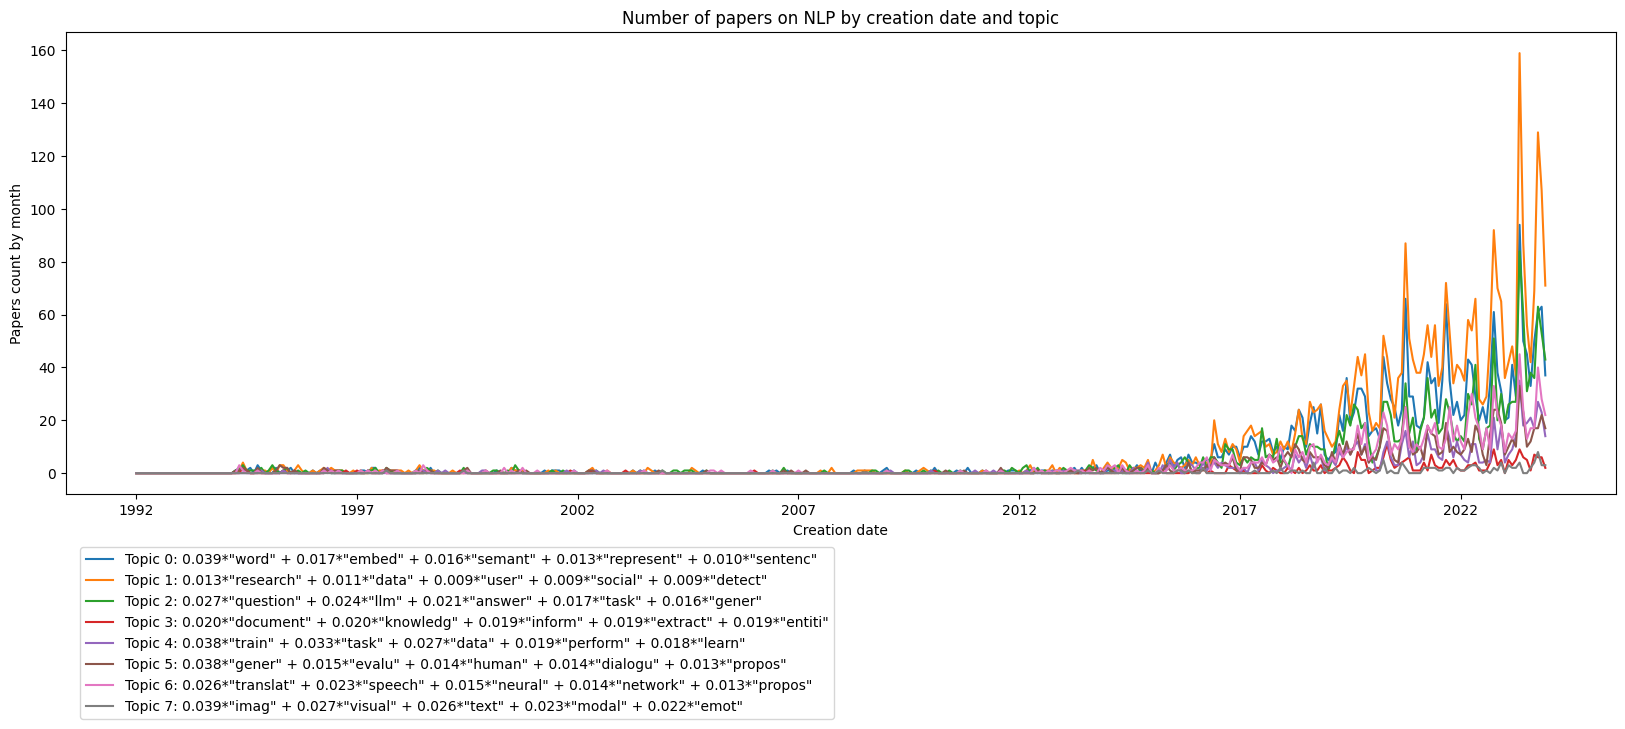

In [165]:
plt.title('Number of papers on NLP by creation date and topic')
#plt.xticks(ticks=range(0,12*(max_year-min_year),60), labels=range(min_year, max_year+1, 5))
plt.xticks(ticks=range(0, (max_year-min_year) * 12, 60), labels=range(min_year, max_year+1, 5))
plt.xlabel('Creation date')
plt.ylabel('Papers count by month')
for key, topic in iter(topics):
    plt.plot(list(timeseries[key]), label=f"Topic {key}: {topic}")
plt.legend(bbox_to_anchor=(0.5, -0.1))
plt.rcParams['figure.figsize'] = (20, 6)
plt.show();

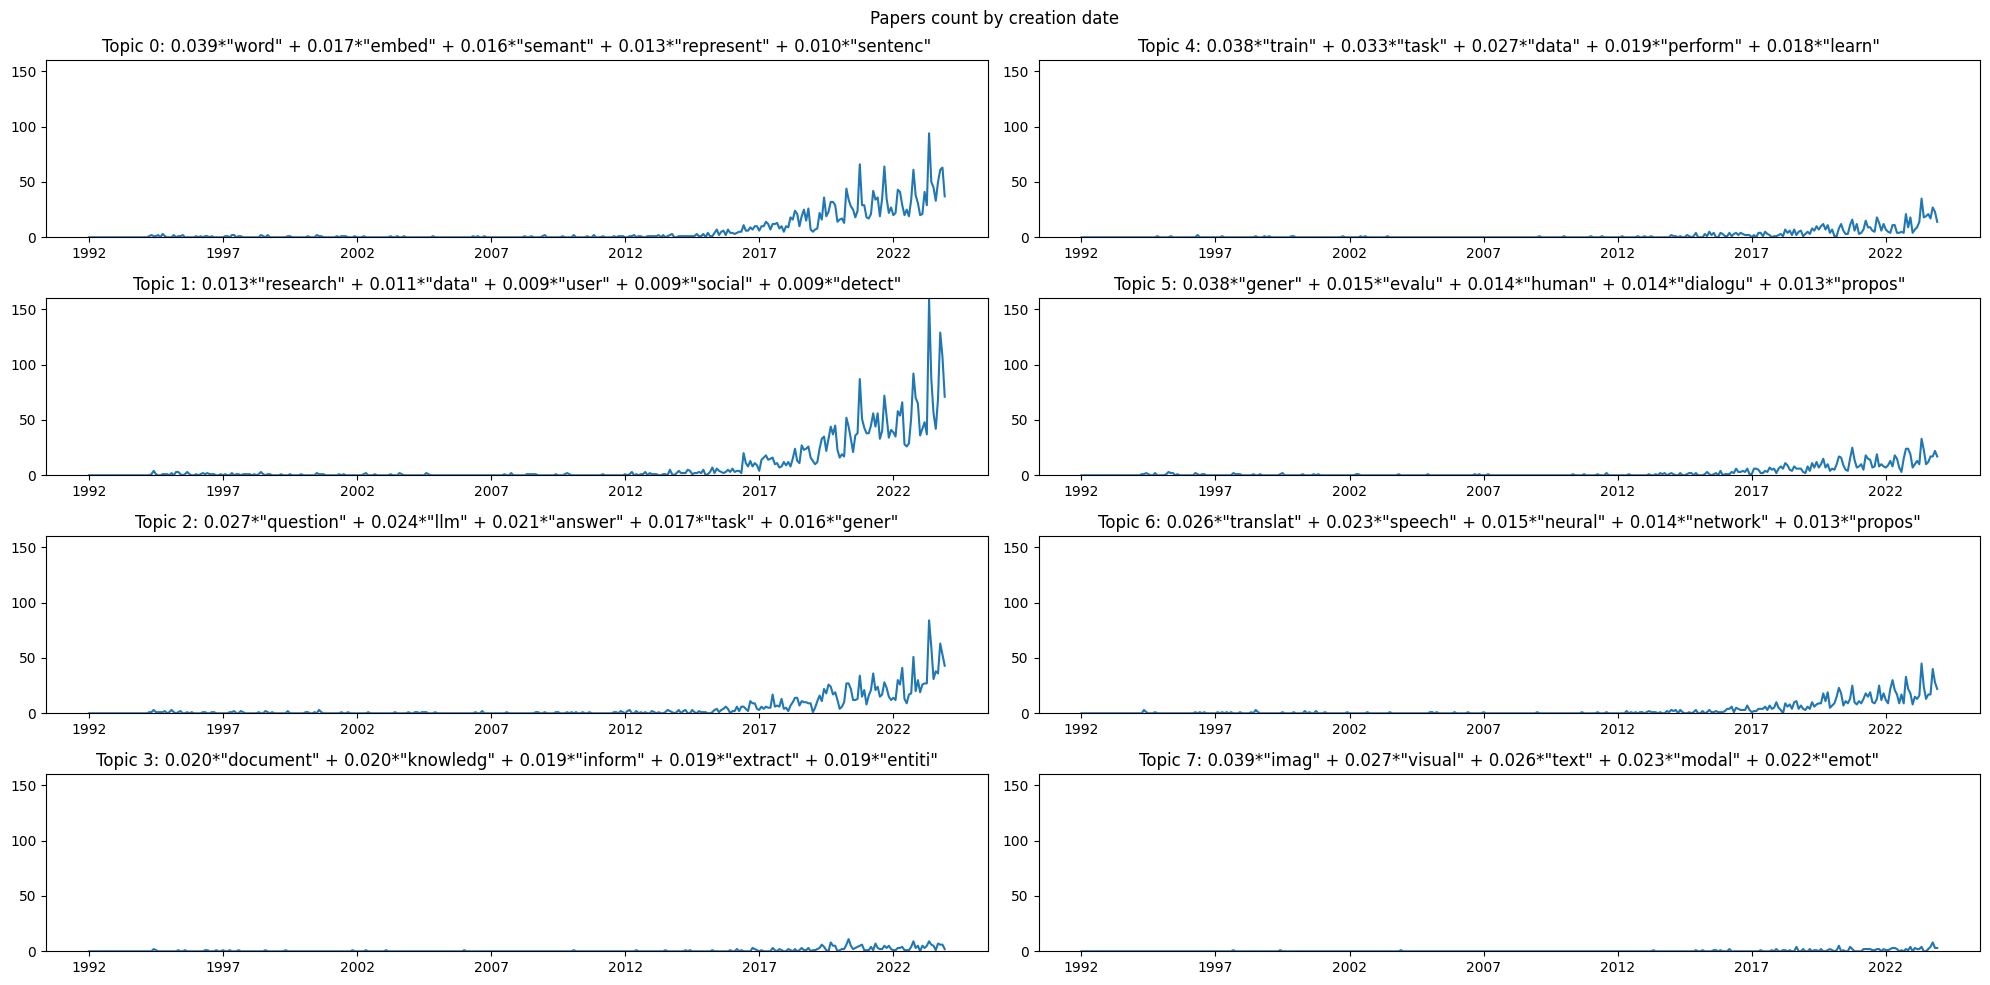

In [215]:
import math
figure, axis = plt.subplots(4, 2)
figure.suptitle('Papers count by topic and creation date')
for key,topic in topics:
    x = key % 4
    y = math.floor(key / 4)
    axis[x, y].plot(list(timeseries[key]))
    axis[x, y].set_xticks(ticks=range(0, (max_year-min_year) * 12, 60), labels=range(min_year, max_year+1, 5))
    axis[x, y].set_ylim([0, 160])
    axis[x, y].set_title(f"Topic {key}: {topic}")
plt.rcParams['figure.figsize'] = (20, 10)
figure.tight_layout()
plt.show()